<a href="https://colab.research.google.com/github/qtuter1997/AI-idea-and-research/blob/main/TopDup_ElasticSearch_vs_Faiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elastic Search

In [ ]:
! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.6.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.6.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.6.2

In [ ]:

import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.6.2/bin/elasticsearch'],
                   stdout=PIPE, stderr=STDOUT,
                   preexec_fn=lambda: os.setuid(1) 
                  )
! sleep 40

In [ ]:
!curl -X GET "localhost:9200/"

{
  "name" : "bef15f39db8c",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "ME_ThUqGTxmrLIgj0bymww",
  "version" : {
    "number" : "7.6.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "ef48eb35cf30adf4db14086e8aabd07ef6fb113f",
    "build_date" : "2020-03-26T06:34:37.794943Z",
    "build_snapshot" : false,
    "lucene_version" : "8.4.0",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
!pip install elasticsearch -q
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
es = Elasticsearch()
es.ping()  

     |████████████████████████████████| 327kB 4.3MB/s 


True

In [ ]:
NUM_DIMENTION = 128
N_QUERY = 300
N_DATA = 1000000
INDEX_NAME = 'test_matrix_array'

create_query = {
    "mappings": {
        "properties": {
            "vector": {
                "type": "dense_vector",
                "dims": NUM_DIMENTION,
            }
        }
    }
}

es.indices.create(index=INDEX_NAME, body=create_query)

{'acknowledged': True,
 'index': 'test_matrix_array',
 'shards_acknowledged': True}

In [ ]:
 es.indices.get_alias("*")

{'test_matrix_array': {'aliases': {}}}

In [ ]:
import numpy as np
import time

In [ ]:


def compute_time(method):
 # Function computing time decorator
  def timed(*args, **kwargs):
    start_time = time.time()
    result = method(*args, **kwargs)
    query_time = time.time() - start_time
    print("--- %s seconds ---" % query_time)
    return result, query_time
  return timed

# @compute_time
# def test_pipeline(index, query):
#   index.search(query, k=top_k)
@compute_time
def generate_dataset(n_data, dim):
    return np.random.random((n_data, dim)).astype('float32')

In [ ]:
@compute_time
def save_data_es(es, n_data, n_dim, index_name):

    data = generate_dataset(n_data, n_dim)[0].tolist()
            
    docs = [{
        "_index": index_name,
        "vector": arr
    } for arr in data]

    bulk(es, docs)

In [ ]:
save_data_es(es, N_DATA, NUM_DIMENTION, INDEX_NAME)

--- 1.6587638854980469 seconds ---
--- 371.99279522895813 seconds ---


(None, 371.99279522895813)

In [ ]:
@compute_time
def query_similarity_vector(vector_query, es, index, topk=10):
    script_query = {
        "script_score" :{
            "query" : {"match_all": {}},
            "script" : {
                "source": "cosineSimilarity(params.query_vector, 'vector')",
                "params" : {"query_vector" : vector_query}
            }
        }
    }

    response = es.search(index=index ,body={"size": topk,"query": script_query})
    return response
# query_similarity_vector(vector_query, es, "test_matrix_array", topk=10)

In [ ]:
query_size = [100, 200, 300, 500, 1000, 1500, 2000, 5000, 8000, 10000]
vector_query = np.random.random(NUM_DIMENTION).astype('float32')

def test_query_time_es(es, index, vector_query, query_size):
    list_query_time = []
    for i, size in enumerate(query_size):
        print(f"Step {i + 1}, testing querying with size {size}:")
        _, query_time = query_similarity_vector(vector_query, es, index=index, topk=size)
        list_query_time.append(query_time)
        print()
    return list_query_time


### Test query time at the first time

In [ ]:
first_running_time_es = test_query_time_es(es, INDEX_NAME, vector_query, query_size)

Step 1, testing querying with size 100:
--- 8.521234273910522 seconds ---

Step 2, testing querying with size 200:
--- 0.44986748695373535 seconds ---

Step 3, testing querying with size 300:
--- 0.4489884376525879 seconds ---

Step 4, testing querying with size 500:
--- 0.6112887859344482 seconds ---

Step 5, testing querying with size 1000:
--- 0.9408888816833496 seconds ---

Step 6, testing querying with size 1500:
--- 1.0319173336029053 seconds ---

Step 7, testing querying with size 2000:
--- 1.0117809772491455 seconds ---

Step 8, testing querying with size 5000:
--- 3.5643110275268555 seconds ---

Step 9, testing querying with size 8000:
--- 3.467865228652954 seconds ---

Step 10, testing querying with size 10000:
--- 2.6701133251190186 seconds ---



### Test query time the second time

In [ ]:
second_running_time_es = test_query_time_es(es, INDEX_NAME, vector_query, query_size)

Step 1, testing querying with size 100:
--- 0.30997776985168457 seconds ---

Step 2, testing querying with size 200:
--- 0.3172588348388672 seconds ---

Step 3, testing querying with size 300:
--- 0.33895444869995117 seconds ---

Step 4, testing querying with size 500:
--- 0.3968043327331543 seconds ---

Step 5, testing querying with size 1000:
--- 0.4583895206451416 seconds ---

Step 6, testing querying with size 1500:
--- 0.5181827545166016 seconds ---

Step 7, testing querying with size 2000:
--- 0.5957620143890381 seconds ---

Step 8, testing querying with size 5000:
--- 0.9026486873626709 seconds ---

Step 9, testing querying with size 8000:
--- 1.362140417098999 seconds ---

Step 10, testing querying with size 10000:
--- 1.5532948970794678 seconds ---



In [ ]:
second_running_time_es = test_query_time_es(es, INDEX_NAME, vector_query, query_size)

Step 1, testing querying with size 100:
--- 0.2976498603820801 seconds ---

Step 2, testing querying with size 200:
--- 0.3046691417694092 seconds ---

Step 3, testing querying with size 300:
--- 0.33043789863586426 seconds ---

Step 4, testing querying with size 500:
--- 0.35054588317871094 seconds ---

Step 5, testing querying with size 1000:
--- 0.427013635635376 seconds ---

Step 6, testing querying with size 1500:
--- 0.4995303153991699 seconds ---

Step 7, testing querying with size 2000:
--- 0.5261430740356445 seconds ---

Step 8, testing querying with size 5000:
--- 0.9145705699920654 seconds ---

Step 9, testing querying with size 8000:
--- 1.216963768005371 seconds ---

Step 10, testing querying with size 10000:
--- 1.4899396896362305 seconds ---



### Test runing time with new vector

In [ ]:
vector_query = np.random.random(NUM_DIMENTION).astype('float32')
running_time_new_vector_es = test_query_time_es(es, INDEX_NAME, vector_query, query_size)

Step 1, testing querying with size 100:
--- 0.3714640140533447 seconds ---

Step 2, testing querying with size 200:
--- 0.371229887008667 seconds ---

Step 3, testing querying with size 300:
--- 0.33730506896972656 seconds ---

Step 4, testing querying with size 500:
--- 0.38135361671447754 seconds ---

Step 5, testing querying with size 1000:
--- 0.6254808902740479 seconds ---

Step 6, testing querying with size 1500:
--- 0.8255596160888672 seconds ---

Step 7, testing querying with size 2000:
--- 0.6919822692871094 seconds ---

Step 8, testing querying with size 5000:
--- 2.0725815296173096 seconds ---

Step 9, testing querying with size 8000:
--- 2.1113197803497314 seconds ---

Step 10, testing querying with size 10000:
--- 2.051396369934082 seconds ---



In [ ]:
# es.indices.put_settings(index=INDEX_NAME,
#                         body= {"index" : {
#                                 "max_result_window" : 20000000
#                               }})

# query = {
#     "match_all": {}
# }


## Elastic Search result visualization

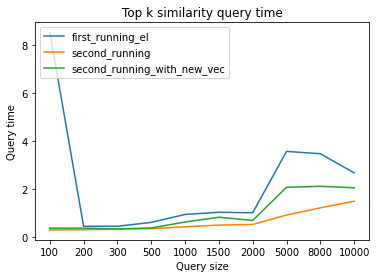

In [ ]:
import matplotlib.pyplot as plt

plt.plot(first_running_time_es)
plt.plot(second_running_time_es)
plt.plot(running_time_new_vector_es)
plt.xticks(range(len(query_size)), [str(size) for size in query_size])
plt.title('Top k similarity query time')
plt.ylabel('Query time')
plt.xlabel('Query size')
plt.legend(['first_running_el', 'second_running', 'second_running_with_new_vec'], loc='upper left')
plt.show()


# Faiss

In [ ]:
!apt install libomp-dev
!python -m pip install --upgrade faiss

     |████████████████████████████████| 4.7MB 5.8MB/s 


In [ ]:
import faiss

index_faiss = faiss.IndexFlatL2(NUM_DIMENTION)
data_faiss = generate_dataset(N_DATA, NUM_DIMENTION)[0]
index_faiss.add(data_faiss)

--- 2.1675617694854736 seconds ---


In [ ]:
print(index_faiss.is_trained)

True


In [ ]:
@compute_time
def query_faiss(index_faiss, vector_query, query_size):
    return index_faiss.search(vector_query, k=query_size)

In [ ]:
query_size = [100, 200, 300, 500, 1000, 1500, 2000, 5000, 8000, 10000]
vector_query = np.random.random((1, NUM_DIMENTION)).astype('float32')

def test_query_time_faiss(index_faiss, vector_query, query_size):
    list_query_time = []
    for i, size in enumerate(query_size):
        print(f"Step {i + 1}, testing querying with size {size}:")
        _, query_time = query_faiss(index_faiss, vector_query, query_size=size)
        list_query_time.append(query_time)
        print()
    return list_query_time


In [ ]:
first_running_time_faiss = test_query_time_faiss(index_faiss, vector_query, query_size)

Step 1, testing querying with size 100:
--- 0.08854460716247559 seconds ---

Step 2, testing querying with size 200:
--- 0.07561326026916504 seconds ---

Step 3, testing querying with size 300:
--- 0.10492420196533203 seconds ---

Step 4, testing querying with size 500:
--- 0.07431292533874512 seconds ---

Step 5, testing querying with size 1000:
--- 0.07536005973815918 seconds ---

Step 6, testing querying with size 1500:
--- 0.07937192916870117 seconds ---

Step 7, testing querying with size 2000:
--- 0.07625436782836914 seconds ---

Step 8, testing querying with size 5000:
--- 0.07779788970947266 seconds ---

Step 9, testing querying with size 8000:
--- 0.08627891540527344 seconds ---

Step 10, testing querying with size 10000:
--- 0.0857551097869873 seconds ---



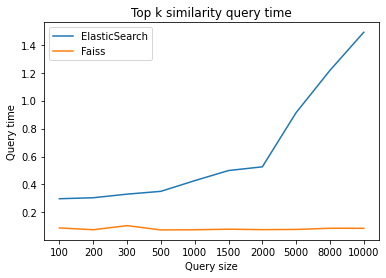

In [ ]:
plt.plot(second_running_time)
plt.plot(first_running_time_faiss)
plt.xticks(range(len(query_size)), [str(size) for size in query_size])
plt.title('Top k similarity query time')
plt.ylabel('Query time')
plt.xlabel('Query size')
plt.legend(['ElasticSearch', 'Faiss'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd
index = ["ElasticSearch", 'Faiss']
df_result = pd.DataFrame([second_running_time, first_running_time_faiss],
                        columns=["query_size="+str(x) for x in query_size], index=index)

In [ ]:
df_result.head()

,query_size=100,query_size=100,query_size=200,query_size=300,query_size=500,query_size=1000,query_size=1500,query_size=2000,query_size=5000,query_size=8000,query_size=10000
ElasticSearch,0.297650,0.304669,0.330438,0.350546,0.427014,0.499530,0.526143,0.914571,1.216964,1.48994,NaN
Faiss,0.084793,0.075434,0.076191,0.073689,0.075210,0.076117,0.074544,0.075104,0.078600,0.07891,0.090949
